In [1]:
import os
from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
import clip

from sklearn.metrics import accuracy_score, f1_score
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**Download Dataset**

Download the dataset from [this Kaggle link](https://www.kaggle.com/datasets/bhavikardeshna/visual-question-answering-computer-vision-nlp) and unzip it under your project folder


The entire possible answers form the answer space and the model answer questioned image by classifying the answer from answer space.


In [2]:
# load dataset
dataset = load_dataset(
    "csv", 
    data_files={
        "train": os.path.join("..","dataset","data_train.csv"),
        "test": os.path.join("..","dataset", "data_eval.csv")
    }
)

with open(os.path.join("..","dataset", "answer_space.txt")) as f:
    answer_space = f.read().splitlines()

dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0]) # Select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

dataset

DatasetDict({
    train: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 9974
    })
    test: Dataset({
        features: ['question', 'answer', 'image_id', 'label'],
        num_rows: 2494
    })
})

image1244


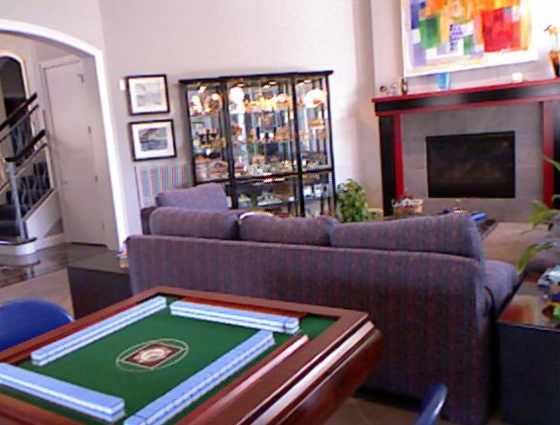

Question:	 what is behind the table
Answer:		 sofa (Label: 452)


In [3]:
# show instance of dataset
from IPython.display import display

def showExample(train=True, id=None):
    if train:
        data = dataset["train"]
    else:
        data = dataset["test"]
    if id == None:
        id = np.random.randint(len(data))
    print(data[id]["image_id"])
    image = Image.open(os.path.join("..","dataset", "images", data[id]["image_id"] + ".png"))
    display(image)

    print("Question:\t", data[id]["question"])
    print("Answer:\t\t", data[id]["answer"], "(Label: {0})".format(data[id]["label"]))

showExample()

**Constructing Model**

In [4]:
import torch
import torch.nn as nn
import clip
from transformers import AutoTokenizer, RobertaModel

class SimpleBaselineNet(nn.Module):
    def __init__(self, num_classes):
        super(SimpleBaselineNet, self).__init__()
        self.clip_model, self.preprocess = clip.load('ViT-B/32', device='cuda', jit=False)
        
        # Freeze parameters of the image encoder
        for param in self.clip_model.visual.parameters():
            param.requires_grad = False
        
        # Freeze parameters of the text encoder
        for param in self.clip_model.transformer.parameters():
            param.requires_grad = False

        # Freeze other parameters
        for param in [
            self.clip_model.positional_embedding,
            self.clip_model.text_projection,
            self.clip_model.logit_scale,
            self.clip_model.token_embedding.weight,
            self.clip_model.ln_final.weight,
            self.clip_model.ln_final.bias
        ]:
            param.requires_grad = False
        
        self.classifier = nn.Linear(512*2, num_classes)

    def forward(self, image, question, device='cuda'):
        # Preprocess and encode image
        image = self.preprocess(image).unsqueeze(0).to(device)
        image_features = self.clip_model.encode_image(image)

        # Tokenize and encode text
        text = clip.tokenize(question).to(device)
        text_features = self.clip_model.encode_text(text)

        # Concatenate features and classify
        concatenated_features = torch.cat((text_features, image_features), dim=1).to(torch.float32)
        logits = self.classifier(concatenated_features)
        return logits



In [5]:
model = SimpleBaselineNet(582)
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.shape)
        
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total number of learnable parameters: {total_params}")

classifier.weight torch.Size([582, 1024])
classifier.bias torch.Size([582])
Total number of learnable parameters: 596550


In [10]:
class Baseline():
    def __init__(self, dataset, batch_size, num_epochs, lr=0.001, num_classes = 582):
        self.num_classes = num_classes
        
        self.model = SimpleBaselineNet(num_classes)
        
        self._num_epochs = num_epochs
        self._batch_size = batch_size
        self._lr = lr

        self.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.DEVICE)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.criterion = torch.nn.CrossEntropyLoss()
        self.initialize_weights()

        self.scheduler = StepLR(self.optimizer, step_size=10, gamma=0.6)
        
        self.train_dataset_loader = DataLoader(dataset["train"], batch_size=1, shuffle=True)
        self.val_dataset_loader = DataLoader(dataset["test"], batch_size=1, shuffle=False)
    
    def initialize_weights(self):
        for m in self.model.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0.01)

    def train(self):
        print('Started Training.\n')
        best_prec = 0.0
        for epoch in range(self._num_epochs):
            self.model.train()  # Set the model to training mode
            train_loss = 0.0
            for batch_id, batch in enumerate(self.train_dataset_loader):
                image_id = batch['image_id'][0]
                labels = batch['label']

                true_answer = torch.zeros(1, self.num_classes, dtype=torch.float32)
                for label in labels:
                    true_answer[0][label] = 1

                true_answer = true_answer.to(self.DEVICE)
                
                question = batch['question']
                image = Image.open(os.path.join("..","dataset", "images", image_id + ".png"))

                predicted_answer = self.model(image, question)

                self.optimizer.zero_grad()
                loss = self.criterion(predicted_answer, true_answer)
                loss.backward()
                self.optimizer.step()

                train_loss += loss.item()
                if batch_id % 100 == 0:  # Log every 100 batches
                    print(f'Epoch [{epoch+1}/{self._num_epochs}], Step [{batch_id}/{len(self.train_dataset_loader)}], Loss: {loss.item():.4f}')

            self.scheduler.step()

            # Print the current learning rate
            print(f"Epoch {epoch+1}, Learning Rate: {self.scheduler.get_last_lr()}")

            if (epoch+1) % 10 == 0:
                model_name = f"clip_baseline_{epoch+1}_{0.001}_{self._batch_size}.pth"
                torch.save(self.model.state_dict(), model_name)
                
        print('Finished Training.')

**Training**

In [11]:
model = Baseline(dataset, batch_size=1, num_epochs=60, lr=0.001)
model.train()

Started Training.

Epoch [1/60], Step [0/9974], Loss: 7.0146
Epoch [1/60], Step [100/9974], Loss: 9.7308
Epoch [1/60], Step [200/9974], Loss: 5.9598
Epoch [1/60], Step [300/9974], Loss: 5.4675
Epoch [1/60], Step [400/9974], Loss: 2.2799
Epoch [1/60], Step [500/9974], Loss: 4.9642
Epoch [1/60], Step [600/9974], Loss: 7.4888
Epoch [1/60], Step [700/9974], Loss: 5.0299
Epoch [1/60], Step [800/9974], Loss: 7.0775
Epoch [1/60], Step [900/9974], Loss: 3.0514
Epoch [1/60], Step [1000/9974], Loss: 4.8383
Epoch [1/60], Step [1100/9974], Loss: 4.8905
Epoch [1/60], Step [1200/9974], Loss: 5.8032
Epoch [1/60], Step [1300/9974], Loss: 5.3104
Epoch [1/60], Step [1400/9974], Loss: 3.4475
Epoch [1/60], Step [1500/9974], Loss: 5.7843
Epoch [1/60], Step [1600/9974], Loss: 6.1753
Epoch [1/60], Step [1700/9974], Loss: 9.0955
Epoch [1/60], Step [1800/9974], Loss: 6.8373
Epoch [1/60], Step [1900/9974], Loss: 5.1042
Epoch [1/60], Step [2000/9974], Loss: 4.7878
Epoch [1/60], Step [2100/9974], Loss: 4.1615
Epo

**Testing**

In [14]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import torch.nn.functional as F
from tqdm import tqdm

def validate(model, val_dataset_loader, device, num_classes, threshold, epoch):
    model.eval()
    val_loss = 0.0
    total_matches = 0
    total_samples = 0

    TP = 0
    FN = 0
    FP = 0
    TN = 0

    criterion = torch.nn.CrossEntropyLoss()
    
    with torch.no_grad(), tqdm(total=len(val_dataset_loader)) as pbar:
        for batch in val_dataset_loader:
            image_id = batch['image_id'][0]
            labels = batch['label']

            true_answer = torch.zeros(1, num_classes, device=device)
            true_answer[0, labels] = 1  # set indices to 1

            question = batch['question']
            image_path = os.path.join("..", "dataset", "images", f"{image_id}.png")
            image = Image.open(image_path)
            predicted_logits = model(image, question)
            
            loss = criterion(predicted_logits, true_answer)
            val_loss += loss.item()
            
            predicted_probs = torch.softmax(predicted_logits, dim=1)
            predicted_labels = (predicted_probs > threshold).float()  # Set threshold probabilities

            for j in range (0, len(predicted_labels[0])):
                if predicted_labels[0][j] == 1:
                    if j in labels:
                        TP += 1
                    else:
                        FP += 1
                else:
                    if j in labels:
                        FN += 1
                    else:
                        TN += 1

            total_matches += ((predicted_labels == true_answer).sum()).item()
            total_samples += len(labels)

            pbar.update(1)

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
    accuracy = (TP + TN) / (TP + FP + FN + TN) if TP + FP + FN + TN > 0 else 0

    print(f'Epoch: {epoch}, threshold: {threshold:.2f}')
    print(f'Precision: {precision:.4f}, Recall: {recall:.4f}')
    print(f'F1 Score: {f1_score:.4f}, Accuracy: {accuracy:.4f}')
    
    return precision, recall
    
num_classes = 582
val_dataset_loader = DataLoader(dataset["test"], batch_size=1, shuffle=True)

epochs = [10, 20, 30, 40, 50, 60]
#epochs = [1]
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]
performances1 = []
for epoch in epochs:
    precisions = []
    recalls = []
    
    model = SimpleBaselineNet(582)
    
    model_name = f"clip_baseline_{epoch}_{0.001}_{1}.pth"
    model.load_state_dict(torch.load(model_name))
    model.to(device)  

    for threshold in thresholds:
        precision, recall = validate(model, val_dataset_loader, device, num_classes, threshold, epoch)
        precisions.append(precision)
        recalls.append(recall)
    performances1.append((precisions, recalls))

100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:38<00:00, 15.78it/s]


Epoch: 10, threshold: 0.10
Precision: 0.1491, Recall: 0.3015
F1 Score: 0.1995, Accuracy: 0.9958


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:43<00:00, 15.24it/s]


Epoch: 10, threshold: 0.30
Precision: 0.2421, Recall: 0.1656
F1 Score: 0.1967, Accuracy: 0.9977


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:46<00:00, 15.02it/s]


Epoch: 10, threshold: 0.50
Precision: 0.3092, Recall: 0.1079
F1 Score: 0.1599, Accuracy: 0.9981


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:45<00:00, 15.11it/s]


Epoch: 10, threshold: 0.70
Precision: 0.3663, Recall: 0.0758
F1 Score: 0.1256, Accuracy: 0.9982


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:42<00:00, 15.36it/s]


Epoch: 10, threshold: 0.90
Precision: 0.4764, Recall: 0.0365
F1 Score: 0.0678, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:47<00:00, 14.93it/s]


Epoch: 20, threshold: 0.10
Precision: 0.1718, Recall: 0.3569
F1 Score: 0.2319, Accuracy: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:47<00:00, 14.89it/s]


Epoch: 20, threshold: 0.30
Precision: 0.3378, Recall: 0.2117
F1 Score: 0.2603, Accuracy: 0.9979


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:44<00:00, 15.17it/s]


Epoch: 20, threshold: 0.50
Precision: 0.4552, Recall: 0.1303
F1 Score: 0.2026, Accuracy: 0.9982


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:44<00:00, 15.18it/s]


Epoch: 20, threshold: 0.70
Precision: 0.5793, Recall: 0.0762
F1 Score: 0.1347, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:50<00:00, 14.65it/s]


Epoch: 20, threshold: 0.90
Precision: 0.7561, Recall: 0.0249
F1 Score: 0.0481, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:44<00:00, 15.20it/s]


Epoch: 30, threshold: 0.10
Precision: 0.1763, Recall: 0.3849
F1 Score: 0.2419, Accuracy: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [03:03<00:00, 13.62it/s]


Epoch: 30, threshold: 0.30
Precision: 0.3292, Recall: 0.2105
F1 Score: 0.2568, Accuracy: 0.9979


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:54<00:00, 14.27it/s]


Epoch: 30, threshold: 0.50
Precision: 0.4654, Recall: 0.1267
F1 Score: 0.1992, Accuracy: 0.9982


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:50<00:00, 14.63it/s]


Epoch: 30, threshold: 0.70
Precision: 0.6094, Recall: 0.0626
F1 Score: 0.1135, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:55<00:00, 14.21it/s]


Epoch: 30, threshold: 0.90
Precision: 0.7059, Recall: 0.0192
F1 Score: 0.0375, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:49<00:00, 14.67it/s]


Epoch: 40, threshold: 0.10
Precision: 0.1824, Recall: 0.3929
F1 Score: 0.2491, Accuracy: 0.9959


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:48<00:00, 14.80it/s]


Epoch: 40, threshold: 0.30
Precision: 0.3414, Recall: 0.2209
F1 Score: 0.2683, Accuracy: 0.9979


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [03:09<00:00, 13.15it/s]


Epoch: 40, threshold: 0.50
Precision: 0.4830, Recall: 0.1307
F1 Score: 0.2057, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [03:03<00:00, 13.60it/s]


Epoch: 40, threshold: 0.70
Precision: 0.6451, Recall: 0.0758
F1 Score: 0.1356, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [03:01<00:00, 13.72it/s]


Epoch: 40, threshold: 0.90
Precision: 0.7356, Recall: 0.0257
F1 Score: 0.0496, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:50<00:00, 14.62it/s]


Epoch: 50, threshold: 0.10
Precision: 0.1876, Recall: 0.4006
F1 Score: 0.2555, Accuracy: 0.9960


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:49<00:00, 14.73it/s]


Epoch: 50, threshold: 0.30
Precision: 0.3483, Recall: 0.2366
F1 Score: 0.2818, Accuracy: 0.9979


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:50<00:00, 14.67it/s]


Epoch: 50, threshold: 0.50
Precision: 0.4726, Recall: 0.1451
F1 Score: 0.2221, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:51<00:00, 14.57it/s]


Epoch: 50, threshold: 0.70
Precision: 0.6228, Recall: 0.0834
F1 Score: 0.1471, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:43<00:00, 15.22it/s]


Epoch: 50, threshold: 0.90
Precision: 0.7442, Recall: 0.0257
F1 Score: 0.0496, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:48<00:00, 14.78it/s]


Epoch: 60, threshold: 0.10
Precision: 0.1927, Recall: 0.4090
F1 Score: 0.2620, Accuracy: 0.9960


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:45<00:00, 15.03it/s]


Epoch: 60, threshold: 0.30
Precision: 0.3517, Recall: 0.2330
F1 Score: 0.2803, Accuracy: 0.9979


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:50<00:00, 14.65it/s]


Epoch: 60, threshold: 0.50
Precision: 0.4838, Recall: 0.1435
F1 Score: 0.2214, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:46<00:00, 15.02it/s]


Epoch: 60, threshold: 0.70
Precision: 0.6091, Recall: 0.0806
F1 Score: 0.1424, Accuracy: 0.9983


100%|██████████████████████████████████████████████████████████████████████████████| 2494/2494 [02:52<00:00, 14.49it/s]

Epoch: 60, threshold: 0.90
Precision: 0.7753, Recall: 0.0277
F1 Score: 0.0534, Accuracy: 0.9983


In [18]:
import pickle

# Save the performances1 data structure to a file
with open('clip_performances1.pickle', 'wb') as handle:
    pickle.dump(performances1, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
# Load the performances1 data structure from a file
with open('clip_performances1.pickle', 'rb') as handle:
    performances1 = pickle.load(handle)

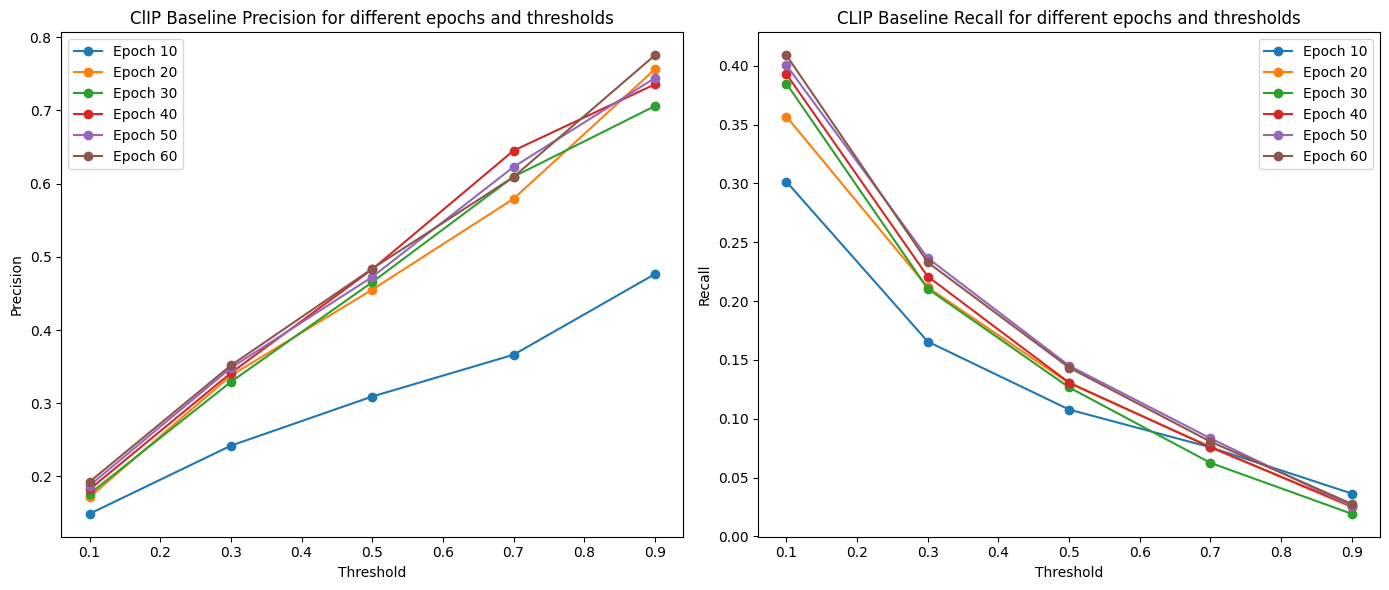

In [17]:
import matplotlib.pyplot as plt

epochs = [10, 20, 30, 40, 50, 60]
thresholds = [0.1, 0.3, 0.5, 0.7, 0.9]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

for i, epoch_data in enumerate(performances1):
    precisions, _ = epoch_data
    ax1.plot(thresholds, precisions, 'o-', label=f'Epoch {epochs[i]}')

for i, epoch_data in enumerate(performances1):
    _, recalls = epoch_data
    ax2.plot(thresholds, recalls, 'o-', label=f'Epoch {epochs[i]}')

ax1.set_title('ClIP Baseline Precision for different epochs and thresholds')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('Precision')
ax1.legend()

ax2.set_title('CLIP Baseline Recall for different epochs and thresholds')
ax2.set_xlabel('Threshold')
ax2.set_ylabel('Recall')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()